In [479]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [480]:
%matplotlib inline

import pandas as pd
from sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

np.set_printoptions(suppress=True)

In [481]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [167]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/profiles'
sho_path = '/home/sobolev/nevermind/Andrey/analysis/showroom'

e_type = 'l'

# 009266
idxs_f = np.array([0, 1, 2, 3, 8, 9, 11, 14, 15, 16], dtype=np.int32)
idxs_d = np.array([4, 5, 10, 12, 13], dtype=np.int32)
idxs_a = np.array([6, 7, 17])

# 009265
idxs_l = np.arange(len(selected_009265))

idxs_types = {'f': idxs_f, 'd': idxs_d, 'a': idxs_a, 'l': idxs_l}

sessions = selected_009265
sessions.sort()
selected = [sessions[i] for i in idxs_types[e_type]]
#selected = sessions

# 57
selected_57_100 = [
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    #"57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    #"57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    #"57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
]
selected_57_75 = [
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_17-10-09",
]

#selected = selected_57_75
selected

['009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34']

## Population average PSTH

In [168]:
coll1, coll2 = [], []
for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file = os.path.join(dst_path, animal, session, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        trials       = np.array(f['processed']['trial_idxs'])
    
    spike_times = {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
            
    hw, bc = 0.25, 51
    sel_units = [unit_name for unit_name in unit_names if int(unit_name[0]) < 3]

    psth1 = np.zeros([len(sel_units), bc - 1])
    psth2 = np.zeros([len(sel_units), bc - 1])
    for i, unit_name in enumerate(sel_units):
        # for target - take only success events!
        idxs_se_succ = np.concatenate([np.arange(r[0], r[1]) for r in tgt_mx[tgt_mx[:, 4] == 1]])
        idxs_se_miss = np.concatenate([np.arange(r[0], r[1]) for r in tgt_mx[tgt_mx[:, 4] == 0]])
        
        bgr_times_all  = sound_events[sound_events[:, 1] == 1][:, 0]
        tgt_times_all  = sound_events[sound_events[:, 1] == 2][:, 0]
        tgt_times_succ = sound_events[idxs_se_succ][:, 0]
        tgt_times_miss = sound_events[idxs_se_miss][:, 0]
        
        bins, psth1[i] = get_spike_counts(spike_times[unit_name], bgr_times_all, hw, bc)
        bins, psth2[i] = get_spike_counts(spike_times[unit_name], tgt_times_all, hw, bc)
    
    # z-score?
#     for j, rec in enumerate(psth1):
#         psth1[j] = np.abs(stats.zscore(rec))
#     for j, rec in enumerate(psth2):
#         psth2[j] = np.abs(stats.zscore(rec))
    
    coll1.append(psth1)
    coll2.append(psth2)
    print(session)
    
psth_bgr = np.vstack(coll1)
psth_tgt = np.vstack(coll2)

009265_hippoSIT_2023-02-28_13-16-10
009265_hippoSIT_2023-02-28_20-45-04
009265_hippoSIT_2023-03-01_10-46-12
009265_hippoSIT_2023-03-02_09-32-54
009265_hippoSIT_2023-03-02_16-27-42
009265_hippoSIT_2023-03-02_20-11-35
009265_hippoSIT_2023-03-03_09-37-07
009265_hippoSIT_2023-03-03_16-00-47
009265_hippoSIT_2023-03-04_11-12-04
009265_hippoSIT_2023-03-05_11-52-17
009265_hippoSIT_2023-03-05_18-31-32
009265_hippoSIT_2023-03-08_18-10-07
009265_hippoSIT_2023-03-09_20-03-08
009265_hippoSIT_2023-03-10_09-57-34


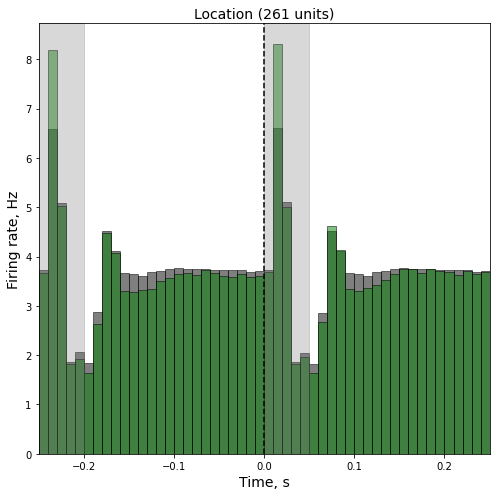

In [169]:
colors = {
    'f': 'orange',
    'd': 'blue',
    'a': 'red',
    'l': 'green'
}
titles = {
    'f': 'Frequency',
    'd': 'Duration',
    'a': 'Amplitude',
    'l': 'Location'
}

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.hist(bins[:-1], bins=bins, weights=psth_bgr.mean(axis=0), edgecolor='black', color='black', alpha=0.5)
ax.hist(bins[:-1], bins=bins, weights=psth_tgt.mean(axis=0), edgecolor='black', color=colors[e_type], alpha=0.5)
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Firing rate, Hz', fontsize=14)
ax.set_title("%s (%d units)" % (titles[e_type], len(psth_bgr)), fontsize=14)
fig.tight_layout()

#fig.savefig(os.path.join(rep_path, '%s_psth_zscored.png' % titles[e_type]), dpi=1000)

In [171]:
bins

array([-0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17,
       -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08,
       -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,
        0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,
        0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,
        0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25])

## PCA

In [172]:
# PCA on GLM fits
pca_bgr = decomposition.PCA(n_components=3)
pca_bgr.fit(psth_bgr)
BGR_X = pca_bgr.transform(psth_bgr)

pca_tgt = decomposition.PCA(n_components=3)
pca_tgt.fit(psth_tgt)
TGT_X = pca_tgt.transform(psth_tgt)

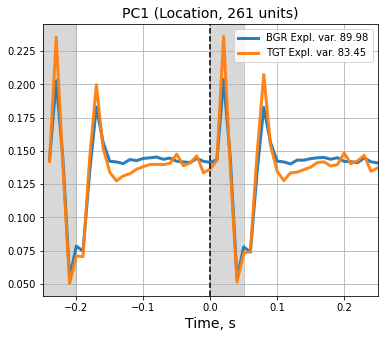

In [173]:
# plot PCA components
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

bin_size = bins[1] - bins[0]

l1 = "BGR Expl. var. %.2f" % float(100*pca_bgr.explained_variance_ratio_[0])
l2 = "TGT Expl. var. %.2f" % float(100*pca_tgt.explained_variance_ratio_[0])
ax.plot(bins[:-1] + bin_size, pca_bgr.components_[0], lw=3, color='tab:blue', alpha=0.95, label=l1)
#ax.plot(bins[:-1], pca_bgr.components_[1], lw=1, color='black', alpha=0.5)
ax.plot(bins[:-1] + bin_size, pca_tgt.components_[0], lw=3, color='tab:orange', alpha=0.95, label=l2)
#ax.plot(bins[:-1], pca_tgt.components_[1], lw=1, color=colors[e_type], alpha=0.5)
ax.axvline(0, color='black', ls='--')
ax.legend(loc='upper right')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_title("PC1 (%s, %d units)" % (titles[e_type], len(psth_bgr)), fontsize=14)
ax.grid()

#fig.savefig(os.path.join(sho_path, '%s_psth_PC1.png' % titles[e_type]), dpi=500)

Text(0, 0.5, 'Variance Explained')

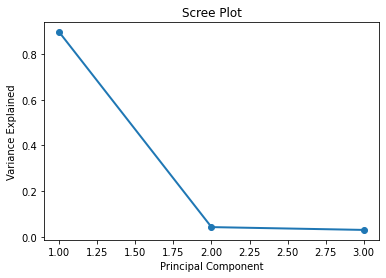

In [11]:
PC_values = np.arange(pca_bgr.n_components_) + 1
plt.plot(PC_values, pca_bgr.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

## ICA

In [13]:
ica_bgr = decomposition.FastICA(n_components=4)
ica_bgr.fit(psth_bgr)
BGR_I = ica_bgr.transform(psth_bgr)

ica_tgt = decomposition.PCA(n_components=4)
ica_tgt.fit(psth_tgt)
TGT_I = ica_tgt.transform(psth_tgt)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


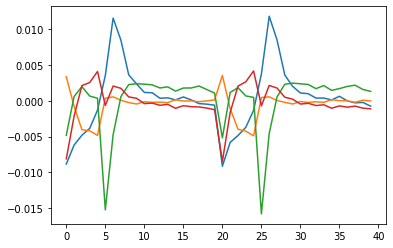

In [16]:
for comp in ica_bgr.components_:
    plt.plot(comp)

In [19]:
ica_tgt.explained_variance_ratio_

array([0.82451486, 0.0705265 , 0.03599864, 0.02622932])

## Clustering on all profiles

In [499]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"

all_selected = selected_009266 + selected_009265 + selected_57
event_type = 'BGR'

label_mx = {
    '009266': 0,
    '009265': 1,
    '57': 2
}
get_label = lambda session: label_mx[session.split('_')[0]]

psths  = []
labels = []
bins   = None
for i, session in enumerate(all_selected):
    animal   = session.split('_')[0]
    psth_file  = os.path.join(dst_path, animal, session, 'analysis', 'psth_micro.h5')

    with h5py.File(psth_file, 'r') as f:
        for unit_name in f['BGR']:
            if int(unit_name[0]) > 2:
                continue
            psths.append(np.array(f['BGR'][unit_name]['profile_stats'][1]))
            labels.append(get_label(session))
            if bins is None:
                bins = np.array(f['BGR'][unit_name]['profile_stats'][0])

psths = np.array(psths)
labels = np.array(labels)

In [500]:
psths.shape

(1137, 50)

In [501]:
#from sklearn.preprocessing import StandardScaler

#psths_scaled = StandardScaler().fit_transform(psths)

psths_scaled = psths.copy()
for i in range(len(psths)):
    #psths_scaled[i] = psths[i]/np.max(psths[i])
    psths_scaled[i] = stats.zscore(psths[i])

In [502]:
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn import decomposition

In [506]:
pca_bgr = decomposition.PCA(n_components=10)
pca_bgr.fit(psths_scaled)
pca_fit = pca_bgr.transform(psths_scaled)
pca_bgr.explained_variance_ratio_

array([0.28430963, 0.25034292, 0.14376734, 0.0931175 , 0.04276462,
       0.03144871, 0.02422385, 0.01844638, 0.01278253, 0.01189753])

In [507]:
np.sum(pca_bgr.explained_variance_ratio_)

0.9131010200607641

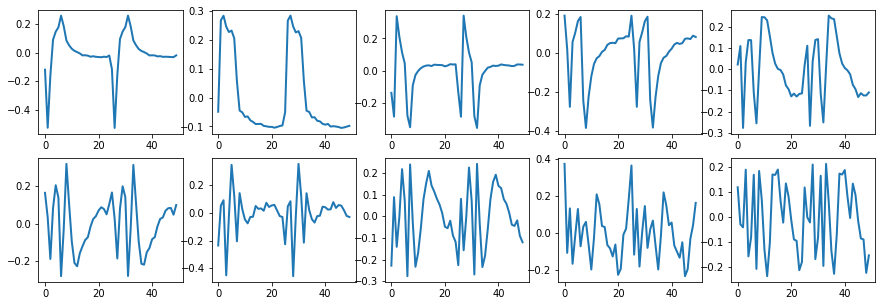

In [511]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[0][i]
    ax.plot(pca_bgr.components_[i], lw=2)
for i in range(5):
    ax = axes[1][i]
    ax.plot(pca_bgr.components_[5 + i], lw=2)

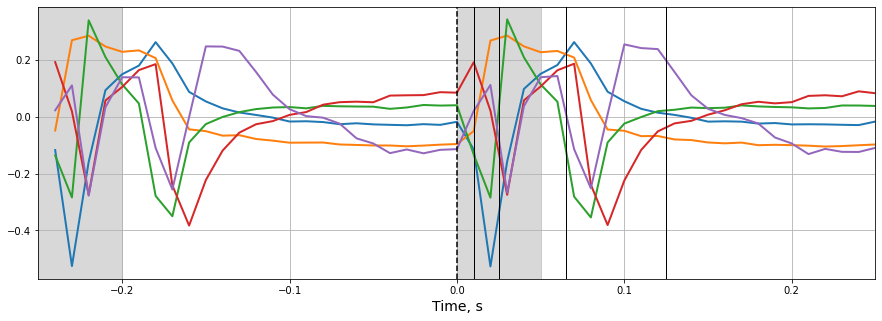

In [368]:
hw = 0.25
bin_size = bins[1] - bins[0]
binning = [10, 25, 65, 125]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for i in range(5):
    ax.plot(bins + bin_size, pca_bgr.components_[i], lw=2)
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.grid()
for x_bin in binning:
    ax.axvline(x_bin/1000, color='black', lw=1)

In [512]:
ica_bgr = decomposition.FastICA(n_components=2)
ica_bgr.fit(psths_scaled)
ica_fit = ica_bgr.transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [513]:
tsne = TSNE(n_components=2, perplexity=70, random_state=0)
tsne_fit = tsne.fit_transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [514]:
umap_2d = UMAP(n_components=2, n_neighbors=30, min_dist=0.5, random_state=0)
umap_fit = umap_2d.fit_transform(psths_scaled)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


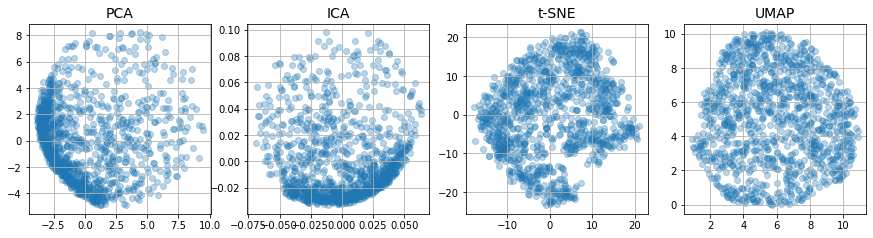

In [515]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3.5))

titles = ['PCA', 'ICA', 't-SNE', 'UMAP']
for i, fit in enumerate([pca_fit, ica_fit, tsne_fit, umap_fit]):
    ax = axes[i]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.3)
    ax.grid()
    ax.set_title(titles[i], fontsize=14)

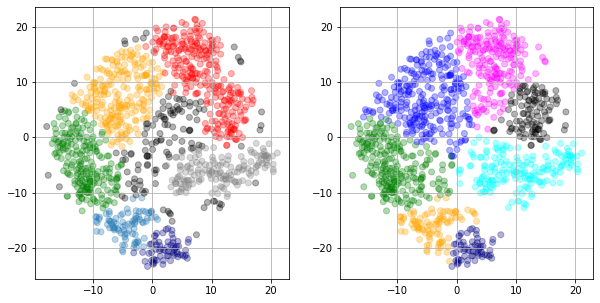

In [629]:
from sklearn.cluster import DBSCAN, KMeans
from skimage.segmentation import watershed
from Behavior.behavior import get_idxs_in_patches, get_extent, density_map

# watershed
extent = get_extent(tsne_fit, margin=5)

# density map
d_map  = density_map(tsne_fit, extent, sigma=0.10, bin_count=100)

# watershed segmentation
mask = d_map > 0.1*d_map.max()
fit_labels = watershed(-d_map, mask=mask)

x_bins = np.linspace(extent[0], extent[1], fit_labels.shape[0]+1)
y_bins = np.linspace(extent[2], extent[3], fit_labels.shape[1]+1)

labels_ev = np.zeros(len(tsne_fit))
for i, record in enumerate(tsne_fit):  # [idxs_succ_ev]
    x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
    y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

    curr_label = fit_labels[x_bin_idx, y_bin_idx]
    labels_ev[i] = curr_label

# DBSCAN
#clustering = DBSCAN(eps=1.36, min_samples=10).fit(tsne_fit)  # kind of good for all 3 animals
#clustering = DBSCAN(eps=2.09, min_samples=25).fit(tsne_fit)
d_clustering = DBSCAN(eps=2.6, min_samples=25).fit(tsne_fit)

# K-Means
k_clustering = KMeans(n_clusters=6, random_state=0).fit(tsne_fit)

# define colors
colors = ['red', 'green', 'blue', 'orange', 'navy', 'cyan', 'black']
colors = ['red', 'green', 'tab:blue', 'orange', 'navy', 'grey', 'black']
#colors = list(reversed(plt.rcParams['axes.prop_cycle'].by_key()['color']))
#colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

d_clrs = [colors[label] for label in d_clustering.labels_]
k_clrs = [colors[label] for label in k_clustering.labels_]
#w_clrs = [colors[label] for label in labels_ev.astype(np.int16)]
clrs = [d_clrs, w_clrs]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axes[i].scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=clrs[i], alpha=0.3)
    axes[i].grid()

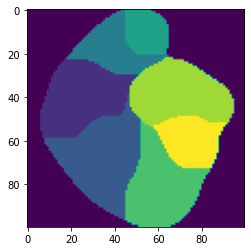

In [620]:
plt.imshow(fit_labels.T)

In [621]:
# select clustering
clustering = d_clustering

In [622]:
clus = np.unique(clustering.labels_)
clu_count = len(clus)
clus, len(np.where([clustering.labels_ == -1])[0])

(array([-1,  0,  1,  2,  3,  4,  5]), 131)

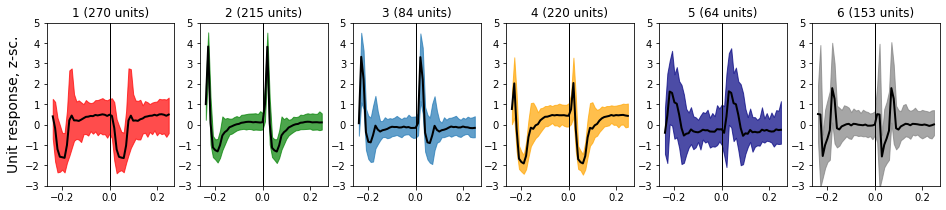

In [630]:
to_plot = psths_scaled

fig, axes = plt.subplots(1, clu_count-1, figsize=(16, 3))

for i in range(clu_count-1):
    sel = to_plot[clustering.labels_ == i]
    mean = sel.mean(axis=0)
    conf_l = np.zeros_like(mean)
    conf_h = np.zeros_like(mean)
    for k, col in enumerate(sel.T):
        conf_l[k] = np.percentile(col, 5)
        conf_h[k] = np.percentile(col, 95)
    
    ax = axes[i]
    #for profile in to_plot[clustering.labels_ == i]:
    #    ax.plot(bins + bin_size, profile, color=colors[i], alpha=0.05)
    ax.fill_between(bins + bin_size, conf_l, conf_h, color=colors[i], alpha=0.7)
    ax.plot(bins + bin_size, to_plot[clustering.labels_ == i].mean(axis=0), lw=2, color='black')
    ax.set_ylim(-3, 5)
    ax.axvline(0, color='black', lw=1)
    ax.set_title('%d (%d units)' % (i+1, len(sel)))
    if i == 0:
        ax.set_ylabel('Unit response, z-sc.', fontsize=14)

### Cluster distribution per animals

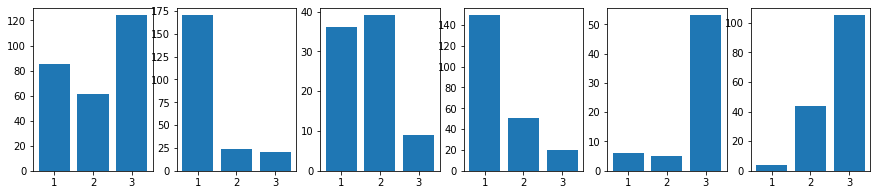

In [525]:
unique_labels = np.unique(labels)

fig, axes = plt.subplots(1, clu_count-1, figsize=(15, 3))

for i in range(clu_count-1):
    ax = axes[i]
    curr_labels = labels[clustering.labels_ == i]
    vals = []
    for j in unique_labels:
        vals.append(len(np.where(curr_labels == j)[0]))
    ax.bar(np.arange(len(unique_labels))+1, vals)

### Principal components - clustering profile means

In [526]:
hw = 0.25
bin_size = bins[1] - bins[0]
binning = [10, 30, 65, 125]

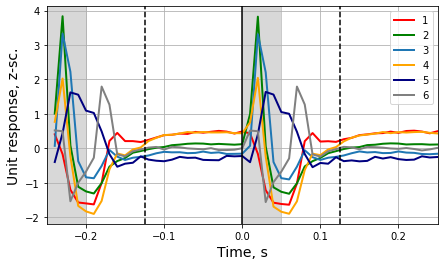

In [631]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(clu_count-1):
    ax.plot(bins + bin_size, to_plot[clustering.labels_ == i].mean(axis=0), lw=2, color=colors[i], label=str(i+1))
ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Unit response, z-sc.', fontsize=14)
ax.legend()
ax.grid()

### Mean rates of change

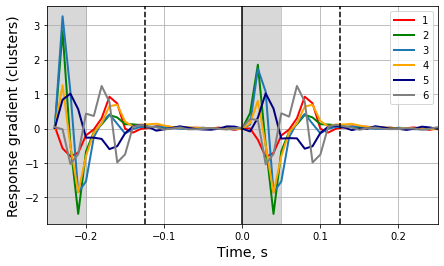

In [634]:
# gradient - no change part
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i in range(clu_count-1):
    grad = np.roll(np.gradient(to_plot[clustering.labels_ == i].mean(axis=0)), 1)
    ax.plot(bins + bin_size, grad, lw=2, color=colors[i], label=str(i+1))
    #print(grad.std(), np.abs(grad[-13:]).max() / grad.std(), np.abs(grad[-13:]).max())
ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Response gradient (clusters)', fontsize=14)
ax.legend()
ax.grid()
# for x_bin in binning:
#     ax.axvline(x_bin/1000, color='black', lw=1)

### All profiles - rates of change

In [635]:
psth_gradients = np.zeros_like(psths)
for i, profile in enumerate(psths):
    psth_gradients[i] = np.roll(np.gradient(profile), 1)

In [636]:
bc = psth_gradients.shape[1]

confidence_l = np.zeros(bc)
confidence_h = np.zeros(bc)
for k, col in enumerate(psth_gradients.T):
    confidence_l[k] = np.percentile(col, 5)
    confidence_h[k] = np.percentile(col, 95)

(-12.0, 12.0)

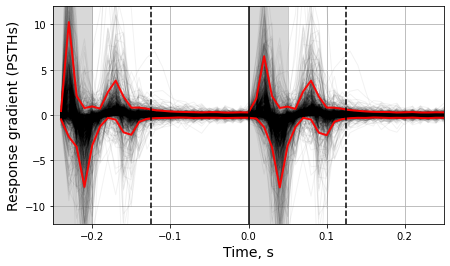

In [606]:
# gradient - for all profiles
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

for i, profile in enumerate(psths):
    ax.plot(bins + bin_size, np.roll(np.gradient(profile), 1), lw=1, color='black', alpha=0.05)
ax.plot(bins + bin_size, confidence_l, lw=2, color='red', alpha=0.95)
ax.plot(bins + bin_size, confidence_h, lw=2, color='red', alpha=0.95)
    
ax.axvline(0, color='black')
ax.axvline(-0.125, color='black', lw=1.5, ls='--')
ax.axvline(0.125, color='black', lw=1.5, ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.axvspan(-0.25, -0.2, alpha=0.3, color='gray')
ax.set_xlim(-hw, hw)
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Response gradient (PSTHs)', fontsize=14)
ax.grid()
ax.set_ylim(-12, 12)